In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

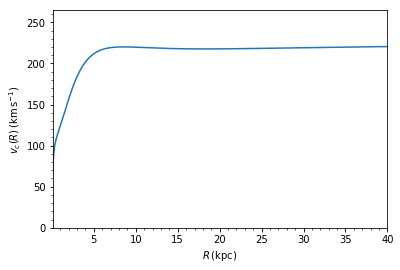

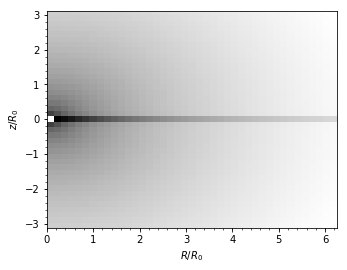

In [3]:
# galpy playtime


r0 = 8.
v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
   
mp.turn_physical_on()
nfwp.turn_physical_on()
hep.turn_physical_on()
pot = [mp,nfwp,hep]

plotRotcurve(pot)
plotDensities(pot, rmin = 0. * units.kpc, rmax = 50. * units.kpc, zmin = -25. * units.kpc, \
              zmax = 25. * units.kpc, log = True, nrs = 41, nzs = 41)


In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [5]:
iall, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() <s.galrad) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [??]')

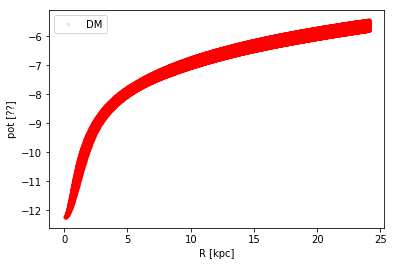

In [6]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

In [7]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)), 50))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]
print(rand_pot_dm)

[-5.85925627 -5.65049505 -6.80746984 -6.83169508 -7.14643145 -6.05453444
 -6.25822449 -7.34617043 -6.09054232 -6.31090164 -6.94022989 -6.02306557
 -7.19933844 -5.89012814 -7.86493444 -7.14428806 -6.34651947 -5.86196756
 -6.61671305 -6.58951092 -9.76270103 -6.69438505 -8.09744072 -6.0186739
 -5.93047857 -5.9876833  -5.83203173 -5.70980692 -6.23605394 -7.23520899
 -5.96731091 -5.82119513 -7.17616367 -6.1062932  -5.90956306 -7.13112259
 -7.94229507 -5.79462385 -6.56347466 -6.49875355 -5.75022507 -6.46663761
 -7.29606438 -5.86451864 -6.04916668 -5.89734936 -6.01140165 -6.77348042
 -5.79466581 -5.90682268]


In [15]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0,\
                  r = None, R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    hep = HEpot(a = a_he * units.kpc, normalize = n_he)
    pot = [mp, nfwp, hep]         
    pot_mod = np.zeros((len(z), len(R)))
    for ii, zii in enumerate(z):
        for jj, Rjj in enumerate(R):
            pot_mod[ii, jj] = evaluatePotentials(pot, Rjj, zii)
    return pot_mod

# FITTING

def RMS(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0 = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    if (n_mp + n_nfw) > 1. :
        print('(n_mp + n_nfw) = ' + str(n_mp + n_nfw))
        RMS = 1000.
    else:
        ydata = pot
        ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0, r, R, z, r0)
        #RMS = np.sqrt(1./N*np.sum((ydata - ymodel)**2))
        RMS = np.sum((ydata - ymodel)**2/(ydata**2))
    print(RMS)
    print(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0)
    return RMS

a_mp = 0.5 
b_mp = 0.1#0.0375 
n_mp = 0.6  
a_nfw = 3 #4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 

v0 = 200.

pot = rand_pot_dm
r, R, z = rand_r_dm, rand_R_dm, rand_z_dm
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , a_he, v0) #n_he

bounds = ((0., None), (0., None), (0., 0.999), (0., None), (0., 0.999), (0., None), (0., None)) #n_he
#r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0 = 8.
N = len(r)
# v0 muss mitgefittet werden
print(x0)
res = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds)


(0.5, 0.1, 0.6, 3, 0.35, 0.075, 200.0)
1627.88777291
0.5 0.1 0.6 3.0 0.35 0.075 200.0
1627.88777231
0.50000001 0.1 0.6 3.0 0.35 0.075 200.0
1627.88777229
0.5 0.10000001 0.6 3.0 0.35 0.075 200.0
1627.88777264
0.5 0.1 0.60000001 3.0 0.35 0.075 200.0
1627.88777009
0.5 0.1 0.6 3.00000001 0.35 0.075 200.0
1627.88775273
0.5 0.1 0.6 3.0 0.35000001 0.075 200.0
1627.8877729
0.5 0.1 0.6 3.0 0.35 0.07500001 200.0
1627.88777291
0.5 0.1 0.6 3.0 0.35 0.075 200.00000001
1321.62472657
0.701271254552 0.309180546822 0.601357543469 3.95693392988 0.352208134615 0.0770287873491 200.0
1321.6247255
0.701271264552 0.309180546822 0.601357543469 3.95693392988 0.352208134615 0.0770287873491 200.0
1321.62472546
0.701271254552 0.309180556822 0.601357543469 3.95693392988 0.352208134615 0.0770287873491 200.0
1321.62472579
0.701271254552 0.309180546822 0.601357553469 3.95693392988 0.352208134615 0.0770287873491 200.0
1321.62472384
0.701271254552 0.309180546822 0.601357543469 3.95693393988 0.352208134615 0.07702878734

137.65116093
1.59956063006 1.24210275653 0.61695997515 8.01640917537 0.37761546135 0.0855832822734 200.0
137.651160337
1.59956063006 1.24210274653 0.61695998515 8.01640917537 0.37761546135 0.0855832822734 200.0
137.651161113
1.59956063006 1.24210274653 0.61695997515 8.01640918537 0.37761546135 0.0855832822734 200.0
137.651149323
1.59956063006 1.24210274653 0.61695997515 8.01640917537 0.37761547135 0.0855832822734 200.0
137.65116188
1.59956063006 1.24210274653 0.61695997515 8.01640917537 0.37761546135 0.0855832922734 200.0
137.65116188
1.59956063006 1.24210274653 0.61695997515 8.01640917537 0.37761546135 0.0855832822734 200.00000001
(n_mp + n_nfw) = 1.01410470291
1000.0
1.68011720746 1.32529508298 0.624248495206 8.24919858159 0.389856207701 0.0860342009264 200.0
(n_mp + n_nfw) = 1.01410470291
1000.0
1.68011721746 1.32529508298 0.624248495206 8.24919858159 0.389856207701 0.0860342009264 200.0
(n_mp + n_nfw) = 1.01410470291
1000.0
1.68011720746 1.32529509298 0.624248495206 8.24919858159 0

136.86599337
1.600837066 1.24342094663 0.617075463286 8.02009777256 0.377809418554 0.0855904271744 200.00000001
128.145206185
1.61578583968 1.25885883451 0.618427983965 8.06329618368 0.380080917081 0.085674103531 200.0
128.145205373
1.61578584968 1.25885883451 0.618427983965 8.06329618368 0.380080917081 0.085674103531 200.0
128.145205359
1.61578583968 1.25885884451 0.618427983965 8.06329618368 0.380080917081 0.085674103531 200.0
128.145204846
1.61578583968 1.25885883451 0.618427993965 8.06329618368 0.380080917081 0.085674103531 200.0
128.145205486
1.61578583968 1.25885883451 0.618427983965 8.06329619368 0.380080917081 0.085674103531 200.0
128.145194821
1.61578583968 1.25885883451 0.618427983965 8.06329618368 0.380080927081 0.085674103531 200.0
128.145206185
1.61578583968 1.25885883451 0.618427983965 8.06329618368 0.380080917081 0.085674113531 200.0
128.145206185
1.61578583968 1.25885883451 0.618427983965 8.06329618368 0.380080917081 0.085674103531 200.00000001
(n_mp + n_nfw) = 1.029271

126.214988853
1.61898420789 1.26216221863 0.618604767845 8.07389393108 0.380658358672 0.0856950037775 200.0
126.214978432
1.61898420789 1.26216221863 0.618604767845 8.07389392108 0.380658368672 0.0856950037775 200.0
126.214989538
1.61898420789 1.26216221863 0.618604767845 8.07389392108 0.380658358672 0.0856950137775 200.0
126.214989538
1.61898420789 1.26216221863 0.618604767845 8.07389392108 0.380658358672 0.0856950037775 200.00000001
(n_mp + n_nfw) = 1.00490210729
1000.0
1.64289686736 1.28686003154 0.619926495818 8.15312810211 0.384975611474 0.0858512648603 200.0
(n_mp + n_nfw) = 1.00490210729
1000.0
1.64289687736 1.28686003154 0.619926495818 8.15312810211 0.384975611474 0.0858512648603 200.0
(n_mp + n_nfw) = 1.00490210729
1000.0
1.64289686736 1.28686004154 0.619926495818 8.15312810211 0.384975611474 0.0858512648603 200.0
(n_mp + n_nfw) = 1.00490211729
1000.0
1.64289686736 1.28686003154 0.619926505818 8.15312810211 0.384975611474 0.0858512648603 200.0
(n_mp + n_nfw) = 1.00490210729
10

1.62036198151 1.26358524037 0.618680921731 8.07845914999 0.38090710545 0.0857040070587 200.0
125.398565844
1.62036198151 1.26358523037 0.618680931731 8.07845914999 0.38090710545 0.0857040070587 200.0
125.398566439
1.62036198151 1.26358523037 0.618680921731 8.07845915999 0.38090710545 0.0857040070587 200.0
125.398556123
1.62036198151 1.26358523037 0.618680921731 8.07845914999 0.38090711545 0.0857040070587 200.0
125.398567118
1.62036198151 1.26358523037 0.618680921731 8.07845914999 0.38090710545 0.0857040170587 200.0
125.398567118
1.62036198151 1.26358523037 0.618680921731 8.07845914999 0.38090710545 0.0857040070587 200.00000001
(n_mp + n_nfw) = 1.0000207708
1000.0
1.6221970739 1.26548057658 0.618782353065 8.0845396967 0.381238417733 0.0857159987623 200.0
(n_mp + n_nfw) = 1.0000207708
1000.0
1.6221970839 1.26548057658 0.618782353065 8.0845396967 0.381238417733 0.0857159987623 200.0
(n_mp + n_nfw) = 1.0000207708
1000.0
1.6221970739 1.26548058658 0.618782353065 8.0845396967 0.381238417733 

119.890479061
1.65392932161 1.29764627979 0.618606567318 8.09613349898 0.380371344754 0.0856749397535 200.00000001
(n_mp + n_nfw) = 1.01250406525
1000.0
1.80422731116 1.45034985144 0.618590093966 8.22686699747 0.39391397128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250406525
1000.0
1.80422732116 1.45034985144 0.618590093966 8.22686699747 0.39391397128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250406525
1000.0
1.80422731116 1.45034986144 0.618590093966 8.22686699747 0.39391397128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250407525
1000.0
1.80422731116 1.45034985144 0.618590103966 8.22686699747 0.39391397128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250406525
1000.0
1.80422731116 1.45034985144 0.618590093966 8.22686700747 0.39391397128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250407525
1000.0
1.80422731116 1.45034985144 0.618590093966 8.22686699747 0.39391398128 0.0856780174796 200.0
(n_mp + n_nfw) = 1.01250406525
1000.0
1.80422731116 1.45034985144 0.618590093966 8.22686699747 0.39

(n_mp + n_nfw) = 1.00167513497
1000.0
1.68389994032 1.32809659078 0.6186032824 8.12220280202 0.383071852574 0.0856755634767 200.0
(n_mp + n_nfw) = 1.00167513497
1000.0
1.68389994032 1.32809659078 0.6186032824 8.12220280202 0.383071852574 0.0856755534767 200.00000001
119.333699127
1.65594182883 1.29969099803 0.618606346738 8.09788403543 0.380552682068 0.0856749809646 200.0
119.333698466
1.65594183883 1.29969099803 0.618606346738 8.09788403543 0.380552682068 0.0856749809646 200.0
119.333698458
1.65594182883 1.29969100803 0.618606346738 8.09788403543 0.380552682068 0.0856749809646 200.0
119.33369804
1.65594182883 1.29969099803 0.618606356738 8.09788403543 0.380552682068 0.0856749809646 200.0
119.333698519
1.65594182883 1.29969099803 0.618606346738 8.09788404543 0.380552682068 0.0856749809646 200.0
119.333689367
1.65594182883 1.29969099803 0.618606346738 8.09788403543 0.380552692068 0.0856749809646 200.0
119.333699127
1.65594182883 1.29969099803 0.618606346738 8.09788403543 0.380552682068 

117.140296451
1.66414742318 1.30802792635 0.618605447367 8.10502150655 0.381292048576 0.0856751489946 200.0
117.140287706
1.66414742318 1.30802792635 0.618605447367 8.10502149655 0.381292058576 0.0856751489946 200.0
117.140297035
1.66414742318 1.30802792635 0.618605447367 8.10502149655 0.381292048576 0.0856751589946 200.0
117.140297035
1.66414742318 1.30802792635 0.618605447367 8.10502149655 0.381292048576 0.0856751489946 200.00000001
(n_mp + n_nfw) = 1.00001329134
1000.0
1.66543410205 1.30933519905 0.618605306341 8.10614068671 0.381407985 0.0856751753426 200.0
(n_mp + n_nfw) = 1.00001329134
1000.0
1.66543411205 1.30933519905 0.618605306341 8.10614068671 0.381407985 0.0856751753426 200.0
(n_mp + n_nfw) = 1.00001329134
1000.0
1.66543410205 1.30933520905 0.618605306341 8.10614068671 0.381407985 0.0856751753426 200.0
(n_mp + n_nfw) = 1.00001330134
1000.0
1.66543410205 1.30933519905 0.618605316341 8.10614068671 0.381407985 0.0856751753426 200.0
(n_mp + n_nfw) = 1.00001329134
1000.0
1.66543

117.798069646
1.66461438162 1.30845667721 0.61866706925 8.10589317906 0.380469738222 0.0856750832794 200.0
117.798069019
1.66461439162 1.30845667721 0.61866706925 8.10589317906 0.380469738222 0.0856750832794 200.0
117.798069013
1.66461438162 1.30845668721 0.61866706925 8.10589317906 0.380469738222 0.0856750832794 200.0
117.798068617
1.66461438162 1.30845667721 0.61866707925 8.10589317906 0.380469738222 0.0856750832794 200.0
117.798069058
1.66461438162 1.30845667721 0.61866706925 8.10589318906 0.380469738222 0.0856750832794 200.0
117.79806022
1.66461438162 1.30845667721 0.61866706925 8.10589317906 0.380469748222 0.0856750832794 200.0
117.798069646
1.66461438162 1.30845667721 0.61866706925 8.10589317906 0.380469738222 0.0856750932794 200.0
117.798069646
1.66461438162 1.30845667721 0.61866706925 8.10589317906 0.380469738222 0.0856750832794 200.00000001
(n_mp + n_nfw) = 1.00049961729
1000.0
1.75625771887 1.40117500496 0.619185980606 8.18959974241 0.381313636688 0.0856763142681 200.0
(n_mp 

112.276051122
1.69633136257 1.34054479195 0.618836590328 8.13487469207 0.380867017924 0.0856755085669 200.0
112.276050638
1.69633137257 1.34054479195 0.618836590328 8.13487469207 0.380867017924 0.0856755085669 200.0
112.276050638
1.69633136257 1.34054480195 0.618836590328 8.13487469207 0.380867017924 0.0856755085669 200.0
112.276050351
1.69633136257 1.34054479195 0.618836600328 8.13487469207 0.380867017924 0.0856755085669 200.0
112.27605061
1.69633136257 1.34054479195 0.618836590328 8.13487470207 0.380867017924 0.0856755085669 200.0
112.276043049
1.69633136257 1.34054479195 0.618836590328 8.13487469207 0.380867027924 0.0856755085669 200.0
112.276051122
1.69633136257 1.34054479195 0.618836590328 8.13487469207 0.380867017924 0.0856755185669 200.0
112.276051122
1.69633136257 1.34054479195 0.618836590328 8.13487469207 0.380867017924 0.0856755085669 200.00000001
(n_mp + n_nfw) = 1.00652864885
1000.0
1.72822778913 1.37275454059 0.618345056915 8.16476846772 0.388183591934 0.0856758871369 200.

112.240970881
1.69643797361 1.34065245024 0.61883494742 8.13497460942 0.380891482937 0.0856755098322 200.0
112.240978946
1.69643797361 1.34065245024 0.61883494742 8.13497460942 0.380891472937 0.0856755198322 200.0
112.240978946
1.69643797361 1.34065245024 0.61883494742 8.13497460942 0.380891472937 0.0856755098322 200.00000001
(n_mp + n_nfw) = 1.00101541885
1000.0
1.70246203237 1.34673568398 0.618742114884 8.14062044127 0.382273303961 0.0856755813301 200.0
(n_mp + n_nfw) = 1.00101541885
1000.0
1.70246204237 1.34673568398 0.618742114884 8.14062044127 0.382273303961 0.0856755813301 200.0
(n_mp + n_nfw) = 1.00101541885
1000.0
1.70246203237 1.34673569398 0.618742114884 8.14062044127 0.382273303961 0.0856755813301 200.0
(n_mp + n_nfw) = 1.00101542885
1000.0
1.70246203237 1.34673568398 0.618742124884 8.14062044127 0.382273303961 0.0856755813301 200.0
(n_mp + n_nfw) = 1.00101541885
1000.0
1.70246203237 1.34673568398 0.618742114884 8.14062045127 0.382273303961 0.0856755813301 200.0
(n_mp + n_nf

14.9795904964 14.6313913262 0.722380314279 22.1190938069 0.549137158858 0.0857323971593 200.0
(n_mp + n_nfw) = 1.27151746314
1000.0
14.9795904964 14.6313913262 0.722380304279 22.1190938169 0.549137158858 0.0857323971593 200.0
(n_mp + n_nfw) = 1.27151747314
1000.0
14.9795904964 14.6313913262 0.722380304279 22.1190938069 0.549137168858 0.0857323971593 200.0
(n_mp + n_nfw) = 1.27151746314
1000.0
14.9795904964 14.6313913262 0.722380304279 22.1190938069 0.549137158858 0.0857324071593 200.0
(n_mp + n_nfw) = 1.27151746314
1000.0
14.9795904964 14.6313913262 0.722380304279 22.1190938069 0.549137158858 0.0857323971593 200.00000001
(n_mp + n_nfw) = 1.04934499748
1000.0
4.12594649484 3.77154410856 0.637784630289 10.6927461711 0.411560367189 0.085685910987 200.0
(n_mp + n_nfw) = 1.04934499748
1000.0
4.12594650484 3.77154410856 0.637784630289 10.6927461711 0.411560367189 0.085685910987 200.0
(n_mp + n_nfw) = 1.04934499748
1000.0
4.12594649484 3.77154411856 0.637784630289 10.6927461711 0.411560367189

112.257288282
1.6969441945 1.34115355318 0.618852455372 8.13557507836 0.380771229146 0.0856755075668 200.0
112.2572878
1.6969442045 1.34115355318 0.618852455372 8.13557507836 0.380771229146 0.0856755075668 200.0
112.2572878
1.6969441945 1.34115356318 0.618852455372 8.13557507836 0.380771229146 0.0856755075668 200.0
112.257287514
1.6969441945 1.34115355318 0.618852465372 8.13557507836 0.380771229146 0.0856755075668 200.0
112.257287771
1.6969441945 1.34115355318 0.618852455372 8.13557508836 0.380771229146 0.0856755075668 200.0
112.257280222
1.6969441945 1.34115355318 0.618852455372 8.13557507836 0.380771239146 0.0856755075668 200.0
112.257288282
1.6969441945 1.34115355318 0.618852455372 8.13557507836 0.380771229146 0.0856755175668 200.0
112.257288282
1.6969441945 1.34115355318 0.618852455372 8.13557507836 0.380771229146 0.0856755075668 200.00000001
109.821909818
1.71317108584 1.35738971872 0.61897893131 8.15265819823 0.380976915241 0.0856755770665 200.0
109.821909418
1.71317109584 1.3573

109.787987477
1.71325137723 1.35746978127 0.618975721914 8.15274645369 0.381009113408 0.0856755772902 200.00000001
109.787982465
1.7132513891 1.3574697931 0.618975721439 8.15274646673 0.381009118168 0.0856755772902 200.0
109.787982066
1.7132513991 1.3574697931 0.618975721439 8.15274646673 0.381009118168 0.0856755772902 200.0
109.787982069
1.7132513891 1.3574698031 0.618975721439 8.15274646673 0.381009118168 0.0856755772902 200.0
109.787981852
1.7132513891 1.3574697931 0.618975731439 8.15274646673 0.381009118168 0.0856755772902 200.0
109.787981996
1.7132513891 1.3574697931 0.618975721439 8.15274647673 0.381009118168 0.0856755772902 200.0
109.78797514
1.7132513891 1.3574697931 0.618975721439 8.15274646673 0.381009128168 0.0856755772902 200.0
109.787982465
1.7132513891 1.3574697931 0.618975721439 8.15274646673 0.381009118168 0.0856755872902 200.0
109.787982465
1.7132513891 1.3574697931 0.618975721439 8.15274646673 0.381009118168 0.0856755772902 200.00000001
109.7768506
1.71327776052 1.357

109.773170888
1.71328645923 1.35750476317 0.618974318073 8.15278501696 0.381023194043 0.0856755773877 200.0
109.77317049
1.71328646923 1.35750476317 0.618974318073 8.15278501696 0.381023194043 0.0856755773877 200.0
109.773170493
1.71328645923 1.35750477317 0.618974318073 8.15278501696 0.381023194043 0.0856755773877 200.0
109.773170276
1.71328645923 1.35750476317 0.618974328073 8.15278501696 0.381023194043 0.0856755773877 200.0
109.773170419
1.71328645923 1.35750476317 0.618974318073 8.15278502696 0.381023194043 0.0856755773877 200.0
109.773163567
1.71328645923 1.35750476317 0.618974318073 8.15278501696 0.381023204043 0.0856755773877 200.0
109.773170888
1.71328645923 1.35750476317 0.618974318073 8.15278501696 0.381023194043 0.0856755873877 200.0
109.773170888
1.71328645923 1.35750476317 0.618974318073 8.15278501696 0.381023194043 0.0856755773877 200.00000001
(n_mp + n_nfw) = 1.00016284691
1000.0
1.71321700699 1.35743363202 0.618949370524 8.15273567934 0.381213476383 0.0856755746989 200.

109.771682436
1.71328566332 1.35750394802 0.618974032178 8.15278445156 0.38102537465 0.0856755773569 200.00000001
(n_mp + n_nfw) = 1.00002637399
1000.0
1.71327433521 1.35749234607 0.618969963073 8.15277640428 0.38105641092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002637399
1000.0
1.71327434521 1.35749234607 0.618969963073 8.15277640428 0.38105641092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002637399
1000.0
1.71327433521 1.35749235607 0.618969963073 8.15277640428 0.38105641092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002638399
1000.0
1.71327433521 1.35749234607 0.618969973073 8.15277640428 0.38105641092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002637399
1000.0
1.71327433521 1.35749234607 0.618969963073 8.15277641428 0.38105641092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002638399
1000.0
1.71327433521 1.35749234607 0.618969963073 8.15277640428 0.38105642092 0.0856755769183 200.0
(n_mp + n_nfw) = 1.00002637399
1000.0
1.71327433521 1.35749234607 0.618969963073 8.15277640428 0.381

1.7132837941 1.35750203361 0.618973360744 8.1527831237 0.381030495874 0.0856755872845 200.0
(n_mp + n_nfw) = 1.00000385662
1000.0
1.7132837941 1.35750203361 0.618973360744 8.1527831237 0.381030495874 0.0856755772845 200.00000001
(n_mp + n_nfw) = 1.998
1000.0
41.5839283623 40.8900164314 0.999 55.0356594912 0.999 0.0856755773879 200.0
(n_mp + n_nfw) = 1.998
1000.0
41.5839283723 40.8900164314 0.999 55.0356594912 0.999 0.0856755773879 200.0
(n_mp + n_nfw) = 1.998
1000.0
41.5839283623 40.8900164414 0.999 55.0356594912 0.999 0.0856755773879 200.0
(n_mp + n_nfw) = 1.99800001
1000.0
41.5839283623 40.8900164314 0.99900001 55.0356594912 0.999 0.0856755773879 200.0
(n_mp + n_nfw) = 1.998
1000.0
41.5839283623 40.8900164314 0.999 55.0356595012 0.999 0.0856755773879 200.0
(n_mp + n_nfw) = 1.99800001
1000.0
41.5839283623 40.8900164314 0.999 55.0356594912 0.99900001 0.0856755773879 200.0
(n_mp + n_nfw) = 1.998
1000.0
41.5839283623 40.8900164314 0.999 55.0356594912 0.999 0.0856755873879 200.0
(n_mp + n

1.71338684942 1.35760429219 0.618975276199 8.15290304966 0.381024739208 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000001541
1000.0
1.71338683942 1.35760430219 0.618975276199 8.15290304966 0.381024739208 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000002541
1000.0
1.71338683942 1.35760429219 0.618975286199 8.15290304966 0.381024739208 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000001541
1000.0
1.71338683942 1.35760429219 0.618975276199 8.15290305966 0.381024739208 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000002541
1000.0
1.71338683942 1.35760429219 0.618975276199 8.15290304966 0.381024749208 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000001541
1000.0
1.71338683942 1.35760429219 0.618975276199 8.15290304966 0.381024739208 0.0856755873879 200.0
(n_mp + n_nfw) = 1.00000001541
1000.0
1.71338683942 1.35760429219 0.618975276199 8.15290304966 0.381024739208 0.0856755773879 200.00000001
109.759837286
1.71337780124 1.35759533066 0.618975190052 8.1528924219 0.38102459912 0.0856755773879 200.0
1

109.759619558
1.71337830793 1.35759583117 0.618975167445 8.15289304373 0.381024804173 0.0856755773879 200.00000001
(n_mp + n_nfw) = 1.00001437633
1000.0
1.71341831311 1.35763534847 0.618973382522 8.15294213942 0.381040993804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001437633
1000.0
1.71341832311 1.35763534847 0.618973382522 8.15294213942 0.381040993804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001437633
1000.0
1.71341831311 1.35763535847 0.618973382522 8.15294213942 0.381040993804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001438633
1000.0
1.71341831311 1.35763534847 0.618973392522 8.15294213942 0.381040993804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001437633
1000.0
1.71341831311 1.35763534847 0.618973382522 8.15294214942 0.381040993804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001438633
1000.0
1.71341831311 1.35763534847 0.618973382522 8.15294213942 0.381041003804 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00001437633
1000.0
1.71341831311 1.35763534847 0.618973382522 8.1529421394

109.759619043
1.7133783182 1.35759583144 0.618975167433 8.15289304406 0.381024804283 0.0856755773879 200.0
109.759619046
1.7133783082 1.35759584144 0.618975167433 8.15289304406 0.381024804283 0.0856755773879 200.0
109.759618829
1.7133783082 1.35759583144 0.618975177433 8.15289304406 0.381024804283 0.0856755773879 200.0
109.759618972
1.7133783082 1.35759583144 0.618975167433 8.15289305406 0.381024804283 0.0856755773879 200.0
109.759612124
1.7133783082 1.35759583144 0.618975167433 8.15289304406 0.381024814283 0.0856755773879 200.0
109.759619441
1.7133783082 1.35759583144 0.618975167433 8.15289304406 0.381024804283 0.0856755873879 200.0
109.759619441
1.7133783082 1.35759583144 0.618975167433 8.15289304406 0.381024804283 0.0856755773879 200.00000001
109.75961943
1.71337830823 1.35759583147 0.618975167432 8.15289304409 0.381024804294 0.0856755773879 200.0
109.759619032
1.71337831823 1.35759583147 0.618975167432 8.15289304409 0.381024804294 0.0856755773879 200.0
109.759619035
1.71337830823 1

1.71337780146 1.35759533088 0.618975200054 8.15289242216 0.381024599124 0.0856755773879 200.0
109.759836785
1.71337780146 1.35759533088 0.618975190054 8.15289243216 0.381024599124 0.0856755773879 200.0
109.759829937
1.71337780146 1.35759533088 0.618975190054 8.15289242216 0.381024609124 0.0856755773879 200.0
109.759837254
1.71337780146 1.35759533088 0.618975190054 8.15289242216 0.381024599124 0.0856755873879 200.0
109.759837254
1.71337780146 1.35759533088 0.618975190054 8.15289242216 0.381024599124 0.0856755773879 200.00000001
(n_mp + n_nfw) = 1.00000128123
1000.0
1.71343733643 1.35765435732 0.618975758208 8.15296247807 0.381025523024 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000128123
1000.0
1.71343734643 1.35765435732 0.618975758208 8.15296247807 0.381025523024 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000128123
1000.0
1.71343733643 1.35765436732 0.618975758208 8.15296247807 0.381025523024 0.0856755773879 200.0
(n_mp + n_nfw) = 1.00000129123
1000.0
1.71343733643 1.35765435732 0.618

109.759836822
1.71337780171 1.35759534113 0.618975190057 8.15289242246 0.381024599128 0.0856755773879 200.0
109.759836605
1.71337780171 1.35759533113 0.618975200057 8.15289242246 0.381024599128 0.0856755773879 200.0
109.759836748
1.71337780171 1.35759533113 0.618975190057 8.15289243246 0.381024599128 0.0856755773879 200.0
109.7598299
1.71337780171 1.35759533113 0.618975190057 8.15289242246 0.381024609128 0.0856755773879 200.0
109.759837217
1.71337780171 1.35759533113 0.618975190057 8.15289242246 0.381024599128 0.0856755873879 200.0
109.759837217
1.71337780171 1.35759533113 0.618975190057 8.15289242246 0.381024599128 0.0856755773879 200.00000001
109.758750422
1.71338524354 1.3576027094 0.618975261076 8.1529011794 0.381024714615 0.0856755773879 200.0
109.758750024
1.71338525354 1.3576027094 0.618975261076 8.1529011794 0.381024714615 0.0856755773879 200.0
109.758750028
1.71338524354 1.3576027194 0.618975261076 8.1529011794 0.381024714615 0.0856755773879 200.0
109.758749811
1.71338524354 1

In [16]:
res


      fun: 1000.0
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -39.82155192,  -39.48140659,  -61.17218447,  -46.85876576,
       -731.69260872,    0.        ,    0.        ])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1544
      nit: 8
   status: 2
  success: False
        x: array([  1.71337780e+00,   1.35759533e+00,   6.18975190e-01,
         8.15289242e+00,   3.81024599e-01,   8.56755774e-02,
         2.00000000e+02])

In [10]:
a_mp, b_mp, n_mp = res.x[0], res.x[1], res.x[2]
a_nfw , n_nfw = res.x[3]  , res.x[4]
a_he, n_he = res.x[5],  res.x[6]

In [11]:
a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot = [mp,nfwp,hep]



In [12]:
dens_final = galpy_fitting(a_mp, b_mp, n_mp, a_nfw , n_nfw, a_he, n_he, R= R, z= z)

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

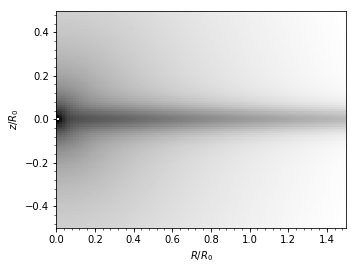

In [13]:
plotDensities(pot,nrs=101,nzs=101, log = True)